# Fit a single point source-point lens event

## Load packages

In [1]:
import os

from typing import Tuple, Callable, Optional, List

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize

import MulensModel as mm

%matplotlib widget

In [2]:
def flux2mag(flux: np.ndarray, 
             zp: Optional[float] = 25.0
             ) -> np.ndarray:
    '''
    Converts flux values (array) to magnitude.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    f : np.ndarray
        Array of magnitudes.
    '''
    f = zp - (2.5 * np.log10(flux))
    return f


def mag2flux(mag: np.ndarray, 
             zp: Optional[float] = 25.0
             ) -> np.ndarray:
    '''
    Converts magnitude values (array) to flux.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    f : np.ndarray
        Array of fluxes.
    '''
    f = 10.0**((mag - zp) / -2.5)
    return f

def mag2flux_err(mag: np.ndarray, mag_err: np.ndarray, 
                 zp: Optional[float] = 25.0):
    '''
    Converts magnitude values and errors (array) to flux using error propagation formula.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    mag_err : np.ndarray
        Array of magnitude errors.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    flux_err : np.ndarray
        Array of flux errors.
    '''
    dfdmag = -0.4 * np.log(10) * 10.**(0.4*(zp-mag))
    flux_err = np.sqrt(dfdmag**2 * mag_err**2)
    return flux_err

def read_data(data_dir: str, 
              extension: Optional[List[str]] = ['dat','diapl','pysis','txt']
              ) -> dict:
    '''
    Reads in the data from a directory.
    
    Parameters
    ----------
    dir : str
        Directory path.
    
    Returns
    -------
    data : dict
        Dictionary containing the data.
        Keys are observatory names, and values are tuples of (t_data, flux_data, flux_err_data).
            t_data : np.ndarray
                Time data.
            mag_data : np.ndarray
                Magnitude data.
            mag_err_data : np.ndarray
                Magnitude error data.
    '''
    data = {} # initalizing data dictinary

    # list of all the 'dat' files in data_directory
    files = [f for f in os.listdir(data_dir) if f.split('.')[-1] in extension] 

    print(files)
    
    files.sort() # alphabetise the data files

    for f in files:

        # creating the path to each data file
        if data_dir[-1] == '/':
            datafile = data_dir + f
        else:
            datafile = data_dir + '/' + f

        # Reading in the data
        t_data = np.loadtxt(datafile, usecols=0)
        if t_data[0] > 2450000:
            t_data = t_data - 2450000
        mag = np.loadtxt(datafile, usecols=1)
        mag_err = np.loadtxt(datafile, usecols=2)

        # This only works because there is only one KMT field (42)
        if 'OGLE' in f:  # (HJD, mag, mag_err, quality?, sky counts?)
            observatory = 'OGLE'
            flux_data = mag2flux(mag, zp=28.)
            flux_err_data = mag2flux_err(mag, mag_err, zp=28)
        if 'KMT' in f:
            flux_data = mag2flux(mag, zp=28.)
            flux_err_data = mag2flux_err(mag, mag_err, zp=28.65)
            
            if 'KMTA' in f:  # (HJD, mag, mag_err)
                observatory = 'KMT-A'
            elif 'KMTC' in f:
                observatory = 'KMT-C'
            elif 'KMTS' in f:
                observatory = 'KMT-S'

        data[observatory] = (t_data, flux_data, flux_err_data)
    
    return data

## Introduction

This notebook was adapted from the [**SingleLens**](https://github.com/AmberLee2427/TheMicrolensersGuideToTheGalaxy/blob/main/Notebooks/SingleLens.ipynb) notebook by Amber Lee Malpas. We highly recommend checking out The Microlensiers Guide to the Galaxy if you're looking for more information on microlensing. We also followed [**MulensModel Example 2**](https://github.com/rpoleski/MulensModel/blob/master/examples/example_02_fitting.py).

In this exercise, you will fit a single point source-point lens microlensing event. Such an event has a single peak, but it may be assymetrical (or even have wobbles) due to the **parallax** effect or have a flatter peak due to the **finite source** effect.

Here, we will focus on fitting the event with the [**MulensModel**](https://github.com/rpoleski/MulensModel) package developed by Radek Poleski, Jennifer Yee and collaborators. There are many other packages you can use in the future:
- [**pyLIMA**](https://github.com/ebachelet/pyLIMA), 
- [**BAGLE**](https://github.com/MovingUniverseLab/BAGLE_Microlensing), 
- [**VBMicrolensing**](https://github.com/valboz/VBMicrolensing),
- [**RTModel**](https://github.com/valboz/RTModel),
- ...,
  
but here we will focus on MulensModel to introduce you to the general idea of how these packages work.

## Load data

In [3]:
# Data directory
data_dir = os.path.abspath('./data/events/OB170002/')

data = read_data(data_dir)

['KMTS42_I.txt', 'OGLE-2017-BLG-0002.txt', 'KMTA42_I.txt', 'KMTC42_I.txt']


Now we will add the data with the `MulensData` class ([**see documentation**](https://rpoleski.github.io/MulensModel/MulensModel.mulensdata.html#module-MulensModel.mulensdata)). This class not only remembers what sort of data we have for each light curve but can also hold information on the units of the data we have, used filters and plotting parameters. It also has some useful methods that can help with working with the data.

In [4]:
OB170002_KMTC_data = mm.MulensData(data_list = data['KMT-C'], 
                                            plot_properties={'color':'purple', 'label':'KMT-C', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_KMTA_data = mm.MulensData(data_list = data['KMT-A'],
                                            plot_properties={'color':'violet', 'label':'KMT-A', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_KMTS_data = mm.MulensData(data_list = data['KMT-S'],
                                            plot_properties={'color':'plum', 'label':'KMT-S', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_OGLE_data = mm.MulensData(data_list = data['OGLE'],
                                            plot_properties={'color':'thistle', 'label':'OGLE', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')

OB170002_data = [OB170002_KMTC_data, OB170002_KMTA_data, OB170002_KMTS_data, OB170002_OGLE_data]

Now lets plot the data!

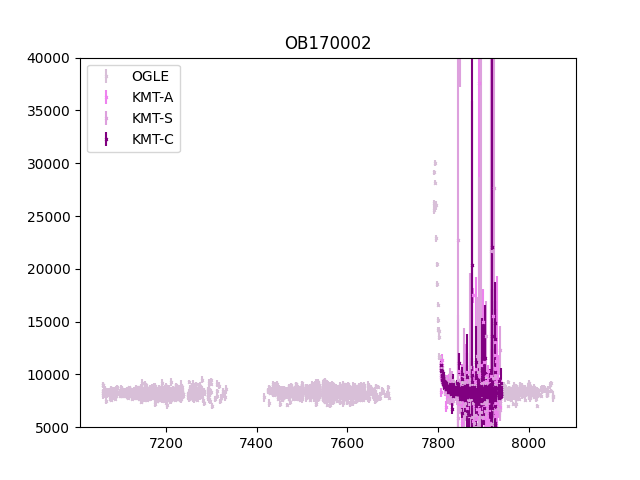

In [5]:
plt.figure()
# MulensModel has a very handy method for MulensData class
OB170002_OGLE_data.plot()
OB170002_KMTA_data.plot()
OB170002_KMTS_data.plot()
OB170002_KMTC_data.plot()

plt.legend()
plt.ylim(5000, 40000)
plt.title('OB170002')
plt.show()

What a pretty event! You can zoom in to check its features.

## Point source-point lens (PSPL)

### Define the PSPL model

Let's define a single event model for this using `MulensModel` `Model` class ([**see documentation**](https://rpoleski.github.io/MulensModel/MulensModel.model.html#module-MulensModel.model)). This model will not have any extra features (for now).

In [6]:
t0, u0, tE = 7792., 0.3, 10 # you can guess the parameters here
Theta0 = np.array([t0, u0, tE])  # initial guess
labels = np.array(['t_0', 'u_0', 't_E']) # parameter labels

# We define the MulensModel model object here
OB170002_pspl = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE}) 

Let's check how well our guess fits to the data.

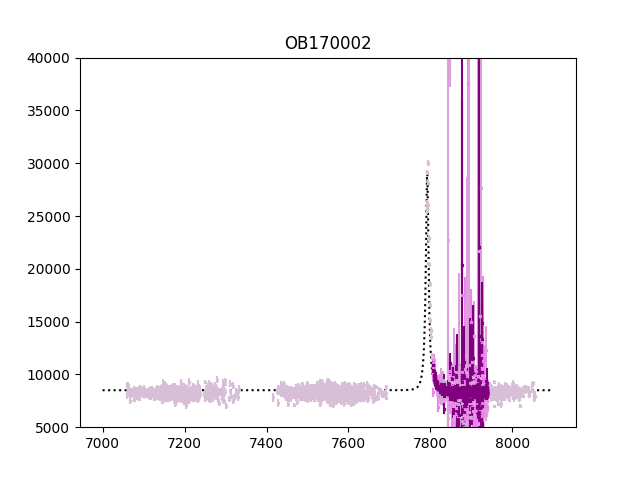

In [7]:
plt.figure()

t = np.linspace(7000, 8100, 2000)  # time range
A0 = OB170002_pspl.get_magnification(t)  # initial guess magnification curve
A0_mag = flux2mag(A0*8500, zp=28.)
plt.plot(t, A0*8500, label='Initial Guess', color='black', linestyle=':')

OB170002_OGLE_data.plot()
OB170002_KMTA_data.plot()
OB170002_KMTS_data.plot()
OB170002_KMTC_data.plot()

plt.title('OB170002')
plt.ylim(5000, 40000)
plt.show()

Nice! Let's try fitting a PSPL model to this event using MulensModel.

### Find best fitting PSPL model

First we have to define a `MulensModel` `Event` object ([**see documentation**](https://rpoleski.github.io/MulensModel/MulensModel.event.html#module-MulensModel.event)). It will rememeber all important information about the event for us.

In [8]:
OB170002 = mm.Event(datasets=OB170002_data, model=OB170002_pspl)

Now, we have to define a function that will measure how well our current model fits to data. In microlensing, we often use $\chi^2$ for this. This means we will be minimizing the $\chi^2$ value to find the best-fitting parameters.

In [9]:
def chi2_fun(theta, parameters_to_fit, event):
    """
    Calculate chi2 for given values of parameters.
    
    Parameters
    ----------
    theta : np.ndarray
        Vector of parameter values, e.g., `np.array([5380., 0.5, 20.])`.
    parameters_to_fit : list of str
        List of names of parameters corresponding to theta, e.g., `['t_0', 'u_0', 't_E']`.
    event : MulensModel.Event
        Event which has datasets for which chi2 will be calculated.
    
    Returns
    -------
    chi2 : float
        Chi2 value for given model parameters.
    
    Notes
    -----
    Function from MulensModel documentation: 
    https://github.com/rpoleski/MulensModel/blob/master/examples/example_02_fitting.py
    """
    # First we have to change the values of parameters in
    # event.model.parameters to values given by theta.
    for (parameter, value) in zip(parameters_to_fit, theta):
        setattr(event.model.parameters, parameter, value)

    # After that, calculating chi2 is trivial:
    return event.get_chi2()

Let's see how well the initial guess fits to the data.

In [10]:
print('Initial Parameter Guess:\n{0}'.format(OB170002.model.parameters))
print('chi^2 = %.2f'%(chi2_fun(Theta0, labels, OB170002)))

Initial Parameter Guess:
    t_0 (HJD)       u_0    t_E (d) 
   7792.00000  0.300000    10.0000 
chi^2 = 28887.42


Let's see if we can find a better fitting model. We will use `minimize` function from `scipy.optimize` package ([**see documentation here**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)).

In [11]:
# Find the best-fit parameters

# Theta0 is our vector with starting parameters. 
# We also have to pass parameter names (labels) and event object (OB170002) 
# to let the fitting function on what event we will be working on
result = minimize(
    chi2_fun, x0=Theta0, args=(labels, OB170002),
    method='Nelder-Mead')

Theta_fit = result.x

print('Final Parameters:\n{0}'.format(OB170002.model.parameters))
print('chi^2 = %.2f'%(chi2_fun(Theta_fit, labels, OB170002)))

print('\nDifference in chi^2 between initial guess and fitted parameters')
print('delta_chi^2 = %.2f'%(chi2_fun(Theta0, labels, OB170002) - chi2_fun(Theta_fit, labels, OB170002)))

Final Parameters:
    t_0 (HJD)       u_0    t_E (d) 
   7792.81524  0.251111    13.9763 
chi^2 = 27518.26

Difference in chi^2 between initial guess and fitted parameters
delta_chi^2 = 1369.16


Great! Let's display our initial and final models!

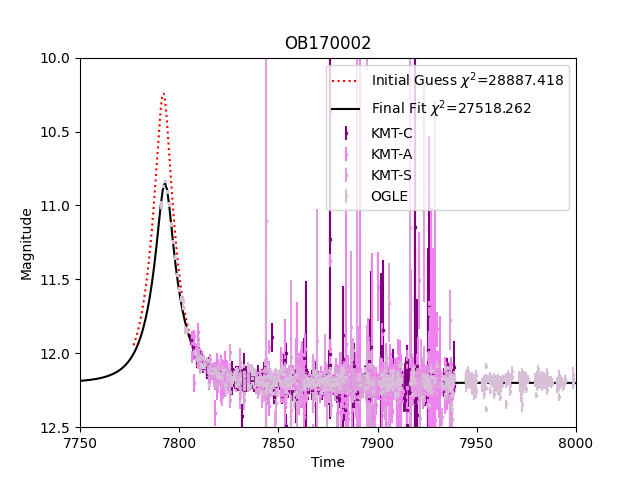

In [15]:
plt.figure()

chi20 = chi2_fun(Theta0, labels, OB170002)  # initial guess chi2

init_model = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
init_fit = mm.FitData(dataset=OB170002_data[0], model=init_model)
init_fit.fit_fluxes()

init_model.plot_lc(
    source_flux=init_fit.source_flux, blend_flux=init_fit.blend_flux,
    label='Initial Guess $\chi^2$=%1.3f'%chi20, color='red', linestyle=':')

chi2_fit = chi2_fun(Theta_fit, labels, OB170002)  # fitted parameters chi2
OB170002.plot_model(label='Final Fit $\chi^2$=%1.3f'%chi2_fit,
                    color='black', linestyle='-', t_range=[7000, 8100])

# MulensModel automatically fits for the source and blend flux for the  
# given model.
OB170002.plot_data()  

plt.legend(loc='best')
plt.title('OB170002')
plt.ylim(12.5, 10)
plt.xlim(7750,8000)
plt.show()

## Add finite source effect

Okay! Now, we will complicate our model a bit. Let's add the finite source effect, which occurs when the source size is comparable to the size of the Einstein ring.

We will follow the same procedure as before. There will be some areas left for you to fill, following the examples above.

### Define FSPL model

In [13]:
t0, u0, tE, rho = 7792, 0.3, 10, 0.01 # some values we guessed.
Theta0FSPL = np.array([t0, u0, tE, rho])  # initial guess
labelsFSPL = np.array(['t_0', 'u_0', 't_E', 'rho']) # parameter labels

OB170002_fspl = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE, 'rho': rho}) 

# Here, we specify that we impose the finite source effect on our event
# We do that by setting the magnification method
OB170002_fspl.set_magnification_methods([2450000., 'finite_source_uniform_Gould94', 2470000.]) # rho <= 0.1

Let's plot the initial guess.

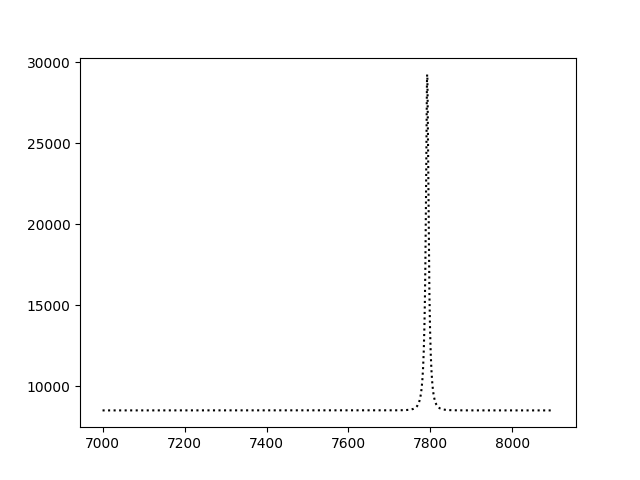

In [14]:
plt.figure()
t = np.linspace(7000, 8100, 2000)  # time range
A0 = OB170002_fspl.get_magnification(t)  # initial guess magnification curve
plt.plot(t, A0*8500, label='Initial Guess', color='black', linestyle=':')

#######
# You can also plot the data here.

#######

plt.show()

### Find best-fitting FSPL model

In [ ]:
# Define the mulens model with the FSPL model like in the example shown before
OB170002 = []

print('Initial Parameter Guess:\n{0}'.format(OB170002.model.parameters))
print('chi^2 = %.2f'%(chi2_fun(Theta0FSPL, labelsFSPL, OB170002)))

In [ ]:
# Now find the best-fitting model similarly like above




In [ ]:
# Plot your results! We already put the initial guess model
plt.figure()

chi20 = chi2_fun(Theta0FSPL, labelsFSPL, OB170002)  # initial guess chi2

init_model = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
init_fit = mm.FitData(dataset=OB170002_data[0], model=init_model)
init_fit.fit_fluxes()

init_model.plot_lc(
    source_flux=init_fit.source_flux, blend_flux=init_fit.blend_flux,
    label='Initial Guess $\chi^2$=%1.3f'%chi20, color='red', linestyle=':')

### If you're feeling adventurous, you can also try plotting the best-fitting PSPL model


#### Put the code for plotting the best-fitting FSPL model





## Add parallax effect

We will now show you how to add the parallax effect to your event. For this, however, we will need a different event. For the previous event parallax effect would be hard to catch because it was short, and all observatories were located on Earth. If we were lucky and had a highly magnified event observed densely, we might catch terrestial parallax like in the case of [**OGLE-2007-BLG-224 event**](https://ui.adsabs.harvard.edu/abs/2009ApJ...698L.147G/abstract).

The parallax effect can (and should) be included, however, in the case of longer events or events which were observed by both Earth- and space-based observatories.

### Load data

In [ ]:
# Data directory
data_dir = os.path.abspath('./data/events/OB170002/')

data = read_data(data_dir)

In [ ]:
OB170002_KMTC_data = mm.MulensData(data_list = data['KMT-C'], 
                                            plot_properties={'color':'purple', 'label':'KMT-C', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_KMTA_data = mm.MulensData(data_list = data['KMT-A'],
                                            plot_properties={'color':'violet', 'label':'KMT-A', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_KMTS_data = mm.MulensData(data_list = data['KMT-S'],
                                            plot_properties={'color':'plum', 'label':'KMT-S', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')
OB170002_OGLE_data = mm.MulensData(data_list = data['OGLE'],
                                            plot_properties={'color':'thistle', 'label':'OGLE', 'marker':'x', 'markersize':2}, 
                                            phot_fmt='flux', 
                                            bandpass='I')

OB170002_data = [OB170002_KMTC_data, OB170002_KMTA_data, OB170002_KMTS_data, OB170002_OGLE_data]

### Define PSPL model with parallax effect

In [ ]:
t0, u0, tE = 7792., 0.3, 10 # you can guess the parameters here
Theta0 = np.array([t0, u0, tE])  # initial guess
labels = np.array(['t_0', 'u_0', 't_E']) # parameter labels

# We define the MulensModel model object here
OB170002_pspl = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE}) 

### Find best-fitting PSPL model with parallax effect

In [ ]:
# Define the mulens model with the FSPL model like in the example shown before
OB170002 = []

print('Initial Parameter Guess:\n{0}'.format(OB170002.model.parameters))
print('chi^2 = %.2f'%(chi2_fun(Theta0FSPL, labelsFSPL, OB170002)))

In [ ]:
# Now find the best-fitting model similarly like above

In [ ]:
# Plot your results! We already put the initial guess model
plt.figure()

chi20 = chi2_fun(Theta0FSPL, labelsFSPL, OB170002)  # initial guess chi2

init_model = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
init_fit = mm.FitData(dataset=OB170002_data[0], model=init_model)
init_fit.fit_fluxes()

init_model.plot_lc(
    source_flux=init_fit.source_flux, blend_flux=init_fit.blend_flux,
    label='Initial Guess $\chi^2$=%1.3f'%chi20, color='red', linestyle=':')

### If you're feeling adventurous, you can also try plotting the best-fitting PSPL model
### Without parallax effect


#### Put the code for plotting the best-fitting PSPL model with parallax

